Projekt na programowanie ewolucyjne

Celem projektu jest znalezienie układu żywych komórek w Conway's game of life na planszy o ograniczonych wymiarach (aby dokonać symulacji) które maksymalizują liczbę żywych komórek po określonej liczbie tur (np. 10, 20,...). Po angielsku funkcjonuje określenie density, określające jaki ułamek komórek w danym momencie jest żywych.

Według https://conwaylife.com/wiki/Density "The maximum density of an n × n still life is greater than or equal to 1/2 for all finite n>1", zawsze da się osiągnąć co najmniej 1/2 zapełnienia planszy żywymi komórkami, jeżeli jest to wzór będący "still life", czyli nie zmieniający się.

Według https://conwaylife.com/ref/lexicon/lex_d.htm#density:
"In 1994 Noam Elkies proved that the maximum density of a stable pattern is 1/2, which had been the conjectured value. See the paper listed in the bibliography. Marcus Moore provided a simpler proof in 1995, and in fact proves that a still life with an m × n bounding box has at most (mn+m+n)/2 cells.

But what is the maximum average density of an oscillating pattern? The answer is conjectured to be 1/2 again, but this remains unproved. The best upper bound so far obtained is 8/13 (Hartmut Holzwart, September 1992). "

W poniższych obliczeniach dzięki algorytmowi SGA udało się osiągnąć wyniki, gdzie density jest zbliżone do 1/2. Obliczenia przeprowadziłem dla umiarkowanie małych plansz (10x10 oraz 20x20), ponieważ już dla nich symulacja game of life zajmowała już około 20-30 minut dla małej liczby tur (10, 20) i około godziny dla większej (50, 100).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng()

In [2]:
# osobnik to np.array 1-d z zerami i jedynkami

def printindividual( v, height, width ):
    print( v.reshape( (height, width) ) )

def imageprintindividual( v, height, width ):
    t = v.reshape( (height, width) )
    fig = plt.figure()
    ax = plt.axes()
    im = ax.imshow(t, cmap='binary')

def simulategameoflife( v, height, width, turns):
    #print("simulation at beginning:")
    #printindividual( v, height, width )

    game = v.reshape( (height, width ) )
    lastnonzero = 0

    around = [ (a, b) for a in [-1, 0, 1] for b in [-1, 0, 1] if (a, b) != (0, 0) ]
    for iturn in range( turns ):
        newgame = np.zeros( game.shape, dtype=int)
        for i in range( height ):
            for j in range( width ):
                neighboursidx = [ (x + i, y + j) for (x, y) in around if (0 <= x + i and x + i < height) and (0 <= y + j and (y + j < width) )]
                #print( neighboursidx )
                #print( np.array( neighboursidx ) )
                #print(  game[ np.array(neighboursidx)[:, 0], np.array(neighboursidx)[:, 1] ]  )
                #aliveneighboursold = np.count_nonzero( game[ np.array(neighboursidx)[:, 0], np.array(neighboursidx)[:, 1] ] )
                aliveneighbours = 0
                for x, y in neighboursidx:
                    if game[x, y] == 1:
                        aliveneighbours += 1

                #if aliveneighbours == 2:
                #    newgame[ i, j ] = game[ i, j ]
                if aliveneighbours == 2 and game[ i, j ] == 1:
                    newgame[ i, j ] = 1
                else:
                    if aliveneighbours == 3:
                        newgame[ i, j ] = 1
                    else:
                        newgame[ i, j ] = 0
                #print(f"i:{i}, j:{j}, game[]:{game[i, j]}, newgame:{newgame[i, j]}, aliveneighbours:{aliveneighbours}")

        #print( newgame )
        #imageprintindividual( game, height, width )

        game = newgame
        if np.count_nonzero(game) > 0:
            lastnonzero = iturn

    return game, lastnonzero
#simulategameoflife( rng.integers(2, size=100), 10, 10, 10 )


In [3]:
def random_individual( d ):
    return rng.integers(2, size=d)

def random_population( n, d ):
    POP = np.zeros( (n, d), dtype=np.int32)
    for i in range(n):
        POP[i] = random_individual( d )
    return POP

def population_evaluation(P, F):
    res = np.zeros(P.shape[0])
    for i in range(P.shape[0]):
        res[i] = F(P[i])
    return res

In [4]:
def gameoflifeobjfunc( v, height, width, turns ):
    game, last = simulategameoflife( v, height, width, turns )
    return np.count_nonzero(game) * (turns) + last

def simplecrossover( v1, v2 ):
    n = v1.shape[0]
    cutoff = rng.choice( n, 1 )[0]
    #print(cutoff)
    for i in range( cutoff, n ):
        tmp = v2[i]
        v2[i] = v1[i]
        v1[i] = tmp
    return v1, v2

#operator mutacji, który zamienia między dwoma osobnikami losowo wybrany kwadrat
def squarecrossover( v1, v2, height, width ):
    x1 = rng.integers( 0, height - 1 )
    y1 = rng.integers( 0, width - 1 )
    x2 = rng.integers( x1, height )
    y2 = rng.integers( y1, width )
    for i in range( x1, x2 + 1 ):
        for j in range( y1, y2 + 1 ):
            idx = i * width + j
            tmp = v2[idx]
            v2[idx] = v1[idx]
            v1[idx] = tmp
    return v1, v2


def simplemutation( v, singleprobability = 0.05 ):
    for i in range( v.shape[0] ):
        if rng.random() < singleprobability:
            if v[i] == 0:
                v[i] = 1
            else:
                v[i] = 0
    return v


In [5]:
def SGA(chromosome_length, population_size, objfunction, crossover_probability = 0.95, mutation_probability = 0.25, number_of_iterations=250):
    number_of_offspring = population_size

    best_objective_value = 0
    best_chromosome = np.zeros((1, chromosome_length))

    # generating an initial population
    current_population = random_population( population_size, chromosome_length )

    # evaluating the objective function on the current population
    objective_values = population_evaluation( current_population, objfunction )

    plotdata = np.zeros((4,number_of_iterations))

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int32)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int32)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = simplecrossover(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = simplemutation(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = population_evaluation( children_population, objfunction )

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)[::-1]
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        # recording some statistics
        if best_objective_value < objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]

        plotdata[0, t] = objective_values.min()
        plotdata[1, t] = objective_values.mean()
        plotdata[2, t] = objective_values.max()
        plotdata[3, t] = objective_values.std()

        if t % 50 == 0:
            print('%3d %12.8f %12.8f %12.8f %12.8f' % (t, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))
    return plotdata, best_chromosome

In [6]:
def objfuncfor10x10t10(v):
    return gameoflifeobjfunc( v, 10, 10, 10 )

def objfuncfor10x10t20(v):
    return gameoflifeobjfunc( v, 10, 10, 20 )

def objfuncfor10x10t50(v):
    return gameoflifeobjfunc( v, 10, 10, 50 )

def objfuncfor10x10t100(v):
    return gameoflifeobjfunc( v, 10, 10, 100 )


def objfuncfor20x20t10(v):
    return gameoflifeobjfunc( v, 20, 20, 10 )

def objfuncfor20x20t20(v):
    return gameoflifeobjfunc( v, 20, 20, 20 )

def objfuncfor20x20t50(v):
    return gameoflifeobjfunc( v, 20, 20, 50 )

def objfuncfor20x20t100(v):
    return gameoflifeobjfunc( v, 20, 20, 100 )
    

def makeplots(plotdata, solution, height, width, turns):
    plt.plot(plotdata[0], label='min')
    plt.plot(plotdata[1], label='mean')
    plt.plot(plotdata[2], label='max')
    plt.legend()
    plt.show()

    print("najlepsza plansza na starcie")
    printindividual(solution, height, width)
    print("plansza po ", turns, " turach")
    printindividual(simulategameoflife(solution, height, width, turns)[0], height, width)

Wyniki w poniższych wykresach są liczone według wzoru tury * (liczba żywych pozostałych komórek) + tury ktore przezyla jakakolwiek komórka, aby rozróżnić plansze z której żadna komórka nie przeżywa 10 tur (lepsze są takie które przeżyją dłużej)

10x10:
10 tur:
  0 169.00000000 229.00000000 359.00000000  48.80573737
 50 459.00000000 485.30000000 539.00000000  23.00673814
100 529.00000000 529.10000000 539.00000000   0.99498744
150 529.00000000 529.10000000 539.00000000   0.99498744
200 529.00000000 529.10000000 539.00000000   0.99498744
250 529.00000000 529.10000000 539.00000000   0.99498744


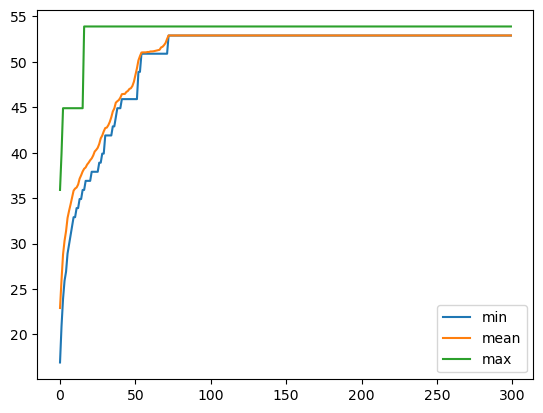

najlepsza plansza na starcie
[[0 0 0 0 0 0 1 1 0 1]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 1]
 [1 1 1 0 1 0 0 0 0 1]
 [0 1 0 1 1 1 1 1 0 0]
 [1 1 1 0 0 0 1 1 0 1]
 [1 1 0 0 1 0 0 1 0 0]
 [0 1 0 0 0 1 1 1 0 0]
 [1 1 1 0 1 1 1 0 1 0]
 [0 1 0 1 1 0 1 1 1 1]]
plansza po  10  turach
[[0 0 0 0 0 1 1 1 1 0]
 [0 0 0 1 1 0 1 0 0 1]
 [0 0 0 1 1 0 0 1 1 1]
 [0 0 0 1 1 0 1 1 1 1]
 [0 0 1 1 1 0 0 0 1 0]
 [0 1 1 1 1 0 1 1 0 1]
 [1 0 1 0 1 1 0 1 1 0]
 [1 1 0 1 1 1 0 0 1 1]
 [1 0 1 0 1 0 0 0 1 1]
 [0 1 1 1 0 0 0 0 1 1]]
20 tur:
  0 239.00000000 366.80000000 679.00000000  99.07148934
 50 739.00000000 746.20000000 859.00000000  15.36749817
100 799.00000000 802.60000000 899.00000000  16.09471963
150 799.00000000 841.20000000 899.00000000  28.69076506
200 859.00000000 861.40000000 899.00000000   7.63151361
250 879.00000000 879.40000000 899.00000000   2.80000000


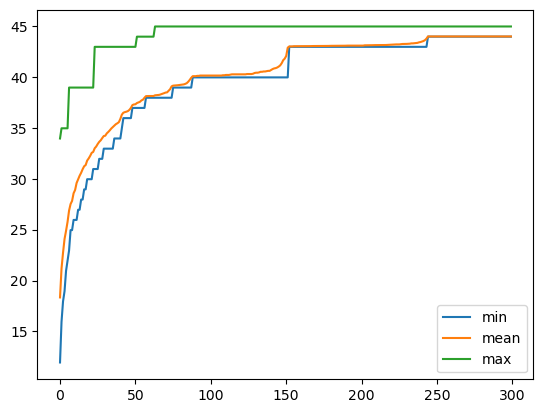

najlepsza plansza na starcie
[[0 0 1 0 1 0 0 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 0 1 0 0 1 1 0 0]
 [1 0 0 1 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 1 1 1]
 [0 0 0 1 0 1 1 0 1 1]
 [0 1 0 0 1 0 1 0 1 1]
 [1 0 0 1 0 1 1 0 0 1]
 [1 0 1 0 1 1 1 0 0 0]
 [1 1 0 1 0 0 0 1 0 1]]
plansza po  20  turach
[[0 0 1 1 1 1 1 0 0 0]
 [0 1 0 0 1 1 1 1 0 0]
 [0 1 0 0 0 0 1 0 1 0]
 [0 1 1 0 1 1 0 1 1 1]
 [0 0 1 0 1 0 0 1 1 1]
 [1 0 0 1 0 0 0 1 1 1]
 [1 0 1 0 0 0 1 0 1 1]
 [0 0 0 1 0 0 1 1 1 0]
 [1 0 1 0 0 0 0 1 0 0]
 [1 0 1 0 0 0 0 0 0 0]]
50 tur:
  0 349.00000000 654.00000000 1699.00000000 262.05915363
 50 1599.00000000 1641.50000000 2049.00000000  58.04093383
100 1849.00000000 1851.00000000 2049.00000000  19.89974874
150 1849.00000000 1853.00000000 2049.00000000  28.00000000
200 1899.00000000 1903.50000000 2049.00000000  25.58808316
250 2049.00000000 2051.00000000 2249.00000000  19.89974874


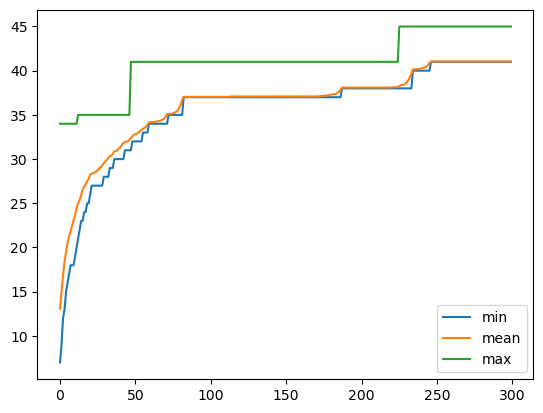

najlepsza plansza na starcie
[[1 0 1 1 0 0 1 1 1 0]
 [1 0 0 1 1 0 1 0 1 0]
 [1 0 1 1 0 0 1 1 1 1]
 [1 0 0 1 0 1 0 1 1 0]
 [1 1 0 0 0 1 1 1 0 0]
 [0 1 1 1 1 0 0 0 1 1]
 [1 1 1 0 0 0 0 1 1 1]
 [1 1 0 1 1 1 0 1 1 1]
 [0 0 0 1 1 0 0 1 0 0]
 [1 0 0 0 0 1 1 0 0 1]]
plansza po  50  turach
[[0 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 1 1 1 0]
 [0 0 0 1 0 0 1 1 1 0]
 [0 0 1 0 1 0 0 0 0 1]
 [0 1 1 0 1 1 1 1 1 0]
 [0 0 1 0 0 0 0 1 1 0]
 [1 0 1 0 0 1 1 0 0 0]
 [1 0 0 1 1 1 1 0 0 0]
 [1 0 1 0 0 0 1 1 1 0]
 [0 1 1 1 1 0 0 1 1 0]]


In [7]:
print("10x10:")
print("10 tur:")
plotdata, solution = SGA(100, 100, objfuncfor10x10t10, number_of_iterations=300)
plotdata /= 10
data10x10t10 = plotdata
makeplots(plotdata, solution, 10, 10, 10)

print("20 tur:")
plotdata, solution = SGA(100, 100, objfuncfor10x10t20, number_of_iterations=300)
plotdata /= 20
data10x10t20 = plotdata
makeplots(plotdata, solution, 10, 10, 20)

print("50 tur:")
plotdata, solution = SGA(100, 100, objfuncfor10x10t50, number_of_iterations=300)
plotdata /= 50
makeplots(plotdata, solution, 10, 10, 50)

20x20:
10 tur:
  0 709.00000000 842.90000000 1149.00000000 105.53572855
 50 1369.00000000 1391.10000000 1449.00000000  17.84908961
100 1449.00000000 1454.30000000 1549.00000000  19.10261762
150 1499.00000000 1501.00000000 1549.00000000   9.79795897
200 1499.00000000 1501.00000000 1549.00000000   9.79795897
250 1499.00000000 1501.00000000 1549.00000000   9.79795897


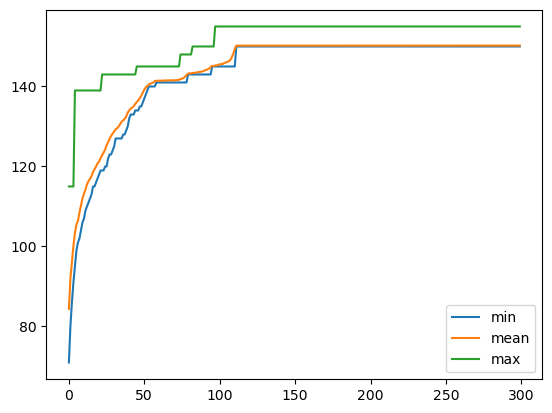

najlepsza plansza na starcie
[[1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1]
 [0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 1 0]
 [1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 0 1]
 [1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1]
 [1 0 1 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1]
 [0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 1 0]
 [0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0]
 [0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1]
 [1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0]
 [1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0]
 [0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0]
 [1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1]
 [0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 1 0 0 1]
 [1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1]
 [0 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1]
 [1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 1]]
plansza po  10  turach
[[0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0]
 [0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 0 1]
 

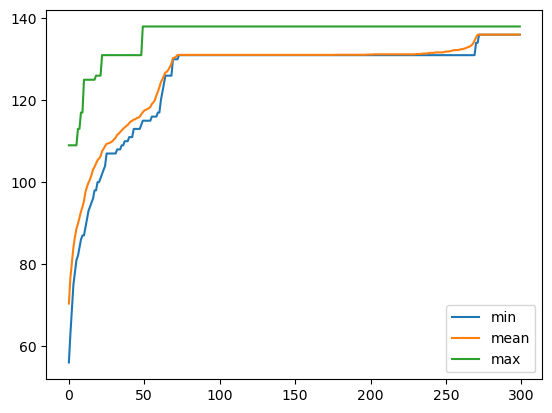

najlepsza plansza na starcie
[[0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 1]
 [1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1]
 [1 0 0 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0]
 [0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1]
 [0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1]
 [0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1]
 [0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0]
 [1 0 0 0 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0]
 [1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 1]
 [1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0]
 [0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1]
 [0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1 0 1 1]
 [0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0]
 [1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0]
 [1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 1 1 0 0]
 [1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 1 1 0 1 0]
 [0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1]
 [1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0]]
plansza po  20  turach
[[0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0]
 

In [8]:
print("20x20:")
print("10 tur:")
plotdata, solution = SGA(400, 100, objfuncfor20x20t10, number_of_iterations=300)
plotdata /= 10
data20x20t10 = plotdata
makeplots(plotdata, solution, 20, 20, 10)

print("20 tur:")
plotdata, solution = SGA(400, 100, objfuncfor20x20t20, number_of_iterations=300)
plotdata /= 20
data20x20t20 = plotdata
makeplots(plotdata, solution, 20, 20, 20)

#print("50 tur:")
#plotdata, solution = SGA(400, 100, objfuncfor20x20t50, number_of_iterations=300)
#plotdata /= 400
#makeplots(plotdata, solution, 20, 20, 50)


SGAsquarecross - algorytm SGA ze zmienionym sposobem crossover, polegającym na wymianie losowo wybranego prostokąta między dwoma osobnikami. Rozumowanie stojące za tym: możliwe że lepszym rozwiązaniem, niż dzielenie
na pół chromosomu, jest wymiana kwadratu z planszy, gdzie u jednego osobnika na tym kwadracie przetrwało zdecydowanie więcej komórek

In [9]:
def SGAsquarecross(chromosome_length, population_size, objfunction, gameheight, gamewidth, crossover_probability = 0.95, mutation_probability = 0.25, number_of_iterations=250):
    number_of_offspring = population_size

    best_objective_value = 0
    best_chromosome = np.zeros((1, chromosome_length))

    # generating an initial population
    current_population = random_population( population_size, chromosome_length )

    # evaluating the objective function on the current population
    objective_values = population_evaluation( current_population, objfunction )

    plotdata = np.zeros((4,number_of_iterations))

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int32)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int32)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = squarecrossover(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy(), gameheight, gamewidth)
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = simplemutation(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = population_evaluation( children_population, objfunction )

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)[::-1]
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        # recording some statistics
        if best_objective_value < objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]

        plotdata[0, t] = objective_values.min()
        plotdata[1, t] = objective_values.mean()
        plotdata[2, t] = objective_values.max()
        plotdata[3, t] = objective_values.std()

        if t % 100 == 0:
            print('%3d %12.8f %12.8f %12.8f %12.8f' % (t, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))
    return plotdata, best_chromosome

10x10 with squarecrossover:
10 tur:
  0 159.00000000 224.90000000 369.00000000  55.84075573
100 479.00000000 479.40000000 499.00000000   2.80000000
200 489.00000000 489.40000000 499.00000000   1.95959179


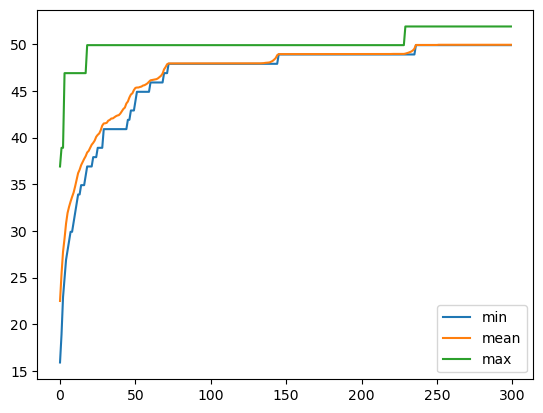

najlepsza plansza na starcie
[[0 0 0 1 1 1 0 1 0 0]
 [1 1 0 0 0 1 0 0 0 0]
 [0 1 1 0 1 1 1 0 1 1]
 [1 1 0 0 1 0 1 0 0 0]
 [0 0 1 1 1 1 0 1 1 1]
 [1 1 0 1 0 0 1 1 0 1]
 [0 0 0 0 0 0 1 1 1 1]
 [0 0 0 1 1 1 0 0 1 1]
 [0 1 1 0 1 0 0 0 1 1]
 [1 1 1 1 1 0 1 1 1 0]]
plansza po  10  turach
[[0 0 1 1 0 0 0 0 1 1]
 [1 0 0 0 1 0 0 0 0 1]
 [0 1 1 1 1 0 0 0 1 1]
 [0 1 1 0 0 0 0 1 1 1]
 [0 0 1 1 1 1 0 1 0 0]
 [0 1 1 1 0 1 1 0 1 0]
 [1 0 1 0 0 0 0 1 1 1]
 [1 0 1 0 0 0 1 0 1 1]
 [0 1 1 0 1 0 1 0 0 0]
 [0 1 1 1 1 1 1 1 1 0]]
20 tur:
  0 219.00000000 370.60000000 619.00000000  94.53803467
100 799.00000000 799.40000000 839.00000000   3.97994975
200 879.00000000 880.60000000 919.00000000   6.11882342


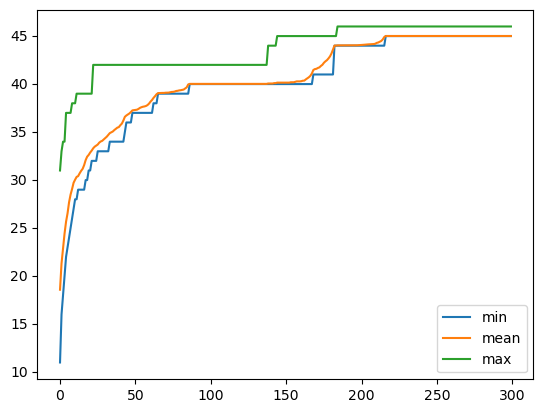

najlepsza plansza na starcie
[[1 1 0 0 0 0 0 1 1 0]
 [1 0 1 0 1 1 1 1 0 1]
 [1 0 0 0 1 1 0 1 0 1]
 [1 0 1 1 0 0 0 1 1 1]
 [1 0 0 1 0 0 0 1 1 0]
 [0 0 1 1 0 0 0 1 1 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 1 1 1 0 0 1]
 [1 0 0 0 1 0 0 1 0 1]
 [1 1 1 0 0 1 0 1 0 0]]
plansza po  20  turach
[[0 1 1 1 0 1 1 1 1 0]
 [1 0 1 0 1 1 0 1 0 1]
 [1 1 0 1 1 0 0 0 0 1]
 [1 0 1 0 0 1 1 1 1 0]
 [0 1 1 0 0 0 1 1 0 0]
 [1 1 0 1 0 0 0 0 0 0]
 [1 0 0 1 1 0 0 0 0 0]
 [1 1 0 1 1 0 0 0 0 0]
 [1 0 0 1 0 0 0 1 1 1]
 [0 1 1 0 0 0 0 0 0 0]]
50 tur:
  0 299.00000000 614.00000000 1199.00000000 239.84369910
100 1949.00000000 1951.50000000 2199.00000000  24.87468593
200 1949.00000000 1951.50000000 2199.00000000  24.87468593


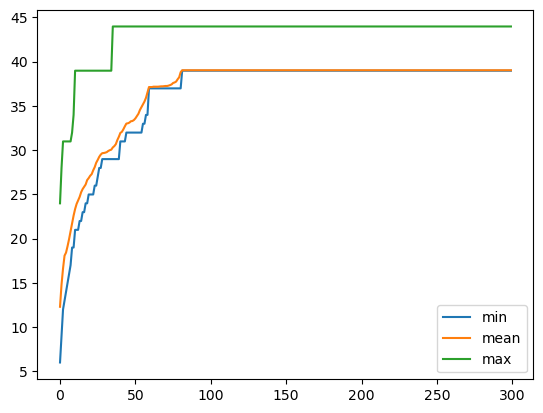

najlepsza plansza na starcie
[[1 1 0 0 1 1 0 0 0 1]
 [1 1 0 1 1 1 0 0 1 0]
 [0 1 1 0 1 1 0 0 1 1]
 [0 0 1 1 1 0 0 1 0 0]
 [0 1 0 1 0 0 0 0 1 1]
 [0 1 0 0 0 1 0 1 0 0]
 [1 1 1 0 1 1 0 0 1 1]
 [0 0 0 1 0 0 0 1 1 0]
 [1 0 1 1 1 0 1 0 1 0]
 [1 1 1 1 1 1 0 1 0 1]]
plansza po  50  turach
[[0 0 0 1 1 1 0 0 0 0]
 [0 1 1 0 1 1 0 1 1 1]
 [0 1 1 0 1 0 1 1 0 1]
 [1 0 0 1 1 1 1 0 0 1]
 [0 1 1 1 1 1 1 1 0 1]
 [1 0 1 0 0 0 0 0 1 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0]]


In [10]:
print("10x10 with squarecrossover:")
print("10 tur:")
plotdata, solution = SGAsquarecross(100, 100, objfuncfor10x10t10, 10, 10, number_of_iterations=300)
plotdata /= 10
datasquare10x10t10 = plotdata
makeplots(plotdata, solution, 10, 10, 10)

print("20 tur:")
plotdata, solution = SGAsquarecross(100, 100, objfuncfor10x10t20, 10, 10, number_of_iterations=300)
plotdata /= 20
datasquare10x10t20 = plotdata
makeplots(plotdata, solution, 10, 10, 20)

print("50 tur:")
plotdata, solution = SGAsquarecross(100, 100, objfuncfor10x10t50, 10, 10, number_of_iterations=300)
plotdata /= 50
makeplots(plotdata, solution, 10, 10, 50)

20x20 with squarecrossover:
10 tur:
  0 719.00000000 872.20000000 1319.00000000 112.54225873
100 1719.00000000 1721.40000000 1749.00000000   8.13879598
200 1719.00000000 1721.40000000 1749.00000000   8.13879598


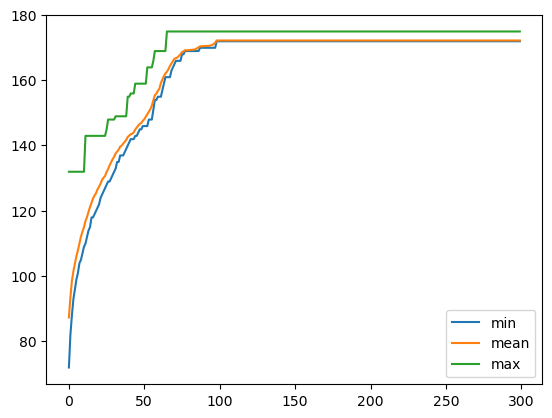

najlepsza plansza na starcie
[[1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0]
 [1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1]
 [1 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0]
 [1 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0 1]
 [0 1 0 1 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 1]
 [1 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1]
 [1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0]
 [0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1]
 [1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0]
 [0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 0]
 [1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1]
 [1 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 1 0]
 [0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1]
 [0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0]
 [0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0]
 [1 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 1]
 [1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1]
 [0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0]
 [1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1]
 [0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0]]
plansza po  10  turach
[[0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 1]
 

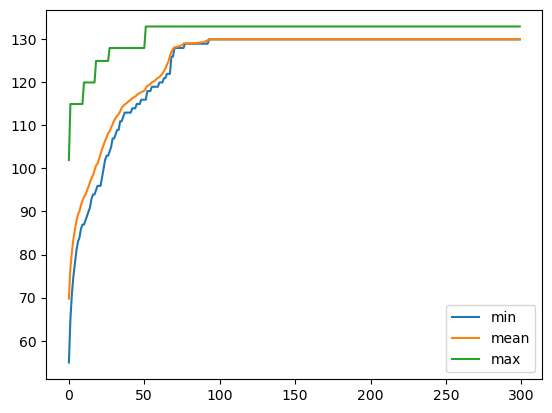

najlepsza plansza na starcie
[[1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1]
 [1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1 0]
 [1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 0]
 [0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1]
 [1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1]
 [0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0]
 [1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1]
 [1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1]
 [1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0]
 [1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0]
 [0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0]
 [1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0]
 [1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0]
 [1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0]
 [0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0]
 [1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1]
 [1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1]]
plansza po  20  turach
[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1]
 

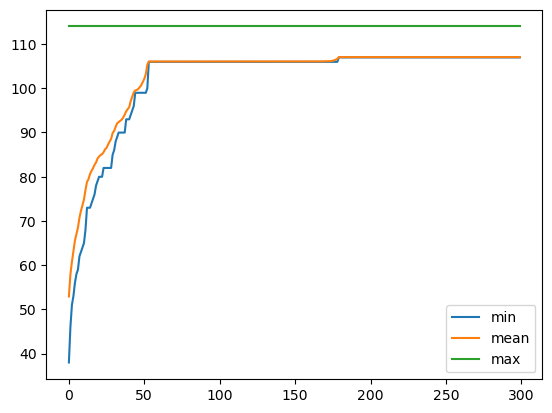

najlepsza plansza na starcie
[[0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0]
 [0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0]
 [0 1 0 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0]
 [0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1]
 [1 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0]
 [1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1]
 [1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0]
 [0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1]
 [0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0]
 [0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0]
 [0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0]
 [1 1 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0]
 [1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0]
 [1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0]
 [0 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 1]
 [1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1]
 [1 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1]
 [1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0]
 [0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1]]
plansza po  50  turach
[[0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
 

In [28]:
print("20x20 with squarecrossover:")
print("10 tur:")
plotdata, solution = SGAsquarecross(400, 100, objfuncfor20x20t10, 20, 20, number_of_iterations=300)
plotdata /= 10
datasquare20x20t10 = plotdata
makeplots(plotdata, solution, 20, 20, 10)

print("20 tur:")
plotdata, solution = SGAsquarecross(400, 100, objfuncfor20x20t20, 20, 20, number_of_iterations=300)
plotdata /= 20
datasquare20x20t20 = plotdata
makeplots(plotdata, solution, 20, 20, 20)

print("50 tur:")
plotdata, solution = SGAsquarecross(400, 100, objfuncfor20x20t50, 20, 20, number_of_iterations=300)
plotdata /= 50
makeplots(plotdata, solution, 20, 20, 50)

In [ ]:
datasquare20x20t50 = plotdata

Porownanie zwyklego crossover z zmodyfikowanym

dla 10x10 10 tur:


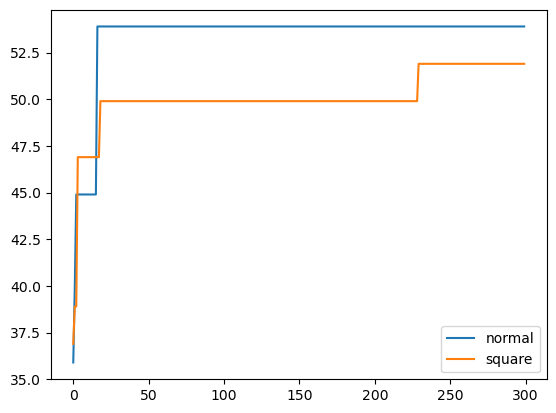

dla 10x10 20 tur:


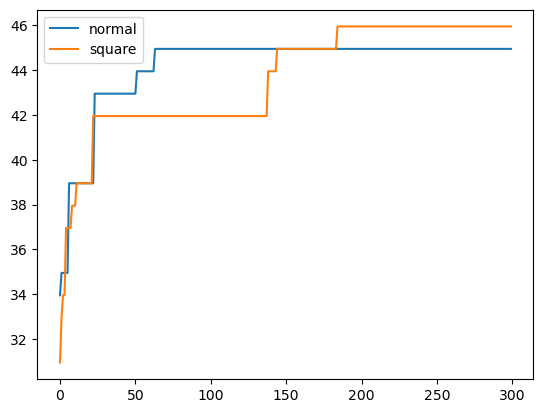

dla 20x20 10 tur:


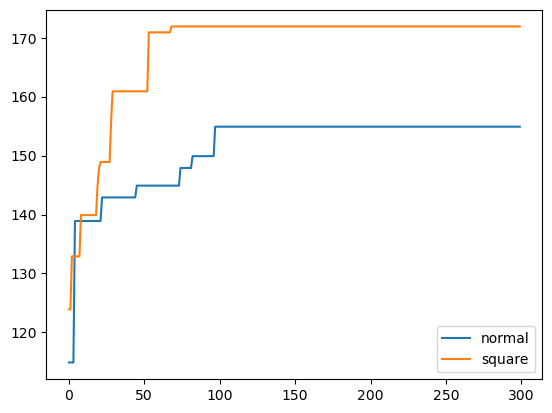

dla 20x20 20 tur:


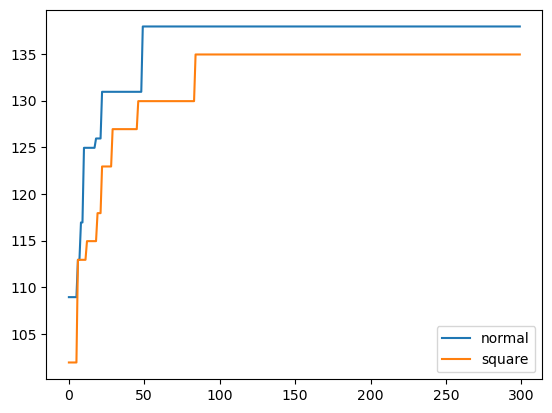

In [27]:
print("dla 10x10 10 tur:")
plt.plot(data10x10t10[2], label='normal')
plt.plot(datasquare10x10t10[2], label='square')
plt.legend()
plt.show()

print("dla 10x10 20 tur:")
plt.plot(data10x10t20[2], label='normal')
plt.plot(datasquare10x10t20[2], label='square')
plt.legend()
plt.show()

print("dla 20x20 10 tur:")
plt.plot(data20x20t10[2], label='normal')
plt.plot(datasquare20x20t10[2], label='square')
plt.legend()
plt.show()

print("dla 20x20 20 tur:")
plt.plot(data20x20t20[2], label='normal')
plt.plot(datasquare20x20t20[2], label='square')
plt.legend()
plt.show()


Porównanie z maksymalnym wynikiem policzonym dla wszystkich możliwych układów komórek początkowych

In [15]:
def bestsolutionslow(height, width, turns = 10):
    n = height * width

    bestres = 0
    solution = np.zeros( n )
    solutionsimulated = np.zeros( n )

    #all subsets of alive cells
    for mask in range( 1, 1 << n ):
        s = [ j for j in range( n ) if (mask & (1 << j)) != 0 ] # subset

        start = np.zeros(n)
        #print(s)
        start[ np.array(s) ] = 1
        #print(mask)

        gameend, _ = simulategameoflife( start, height, width, turns )
        res = np.count_nonzero(gameend)
        if res > bestres:
            bestres = res
            solution = np.array(start)
            solutionsimulated = gameend

    
    return solution, solutionsimulated, bestres
                

In [16]:
# 4x4
brutesolution, brutesim, bruteres = bestsolutionslow(4, 4, 10)


dla 4x4 najlepsze rozwiazanie po 10 turach ma 12 zywych komorek, wyglada ono tak:
po 10 turach:


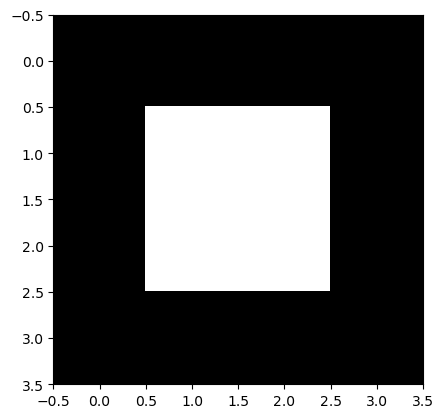

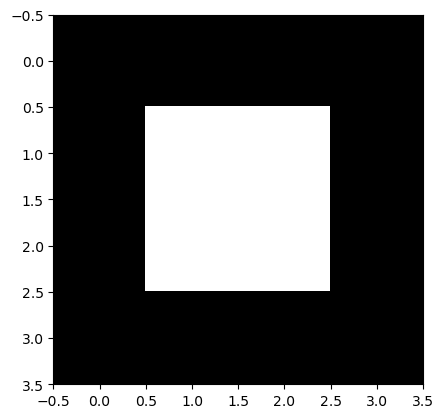

In [17]:
print("dla 4x4 najlepsze rozwiazanie po 10 turach ma", bruteres, "zywych komorek, wyglada ono tak:")
imageprintindividual(brutesolution, 4, 4)
print("po 10 turach:")
imageprintindividual(brutesim, 4, 4)

  0  39.00000000  61.90000000 109.00000000  16.86979549
 50 119.00000000 121.80000000 129.00000000   4.48998886
100 129.00000000 129.00000000 129.00000000   0.00000000
150 129.00000000 129.00000000 129.00000000   0.00000000
200 129.00000000 129.00000000 129.00000000   0.00000000
250 129.00000000 129.00000000 129.00000000   0.00000000
300 129.00000000 129.00000000 129.00000000   0.00000000
350 129.00000000 129.00000000 129.00000000   0.00000000


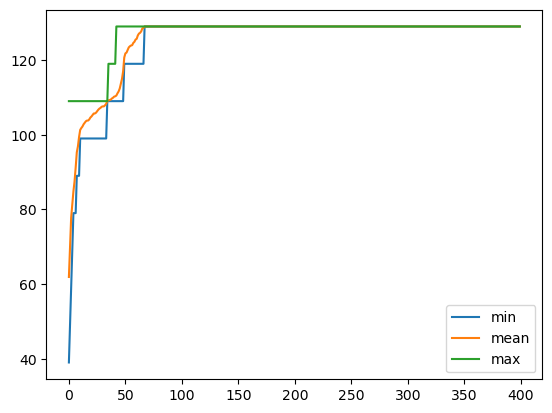

najlepsza plansza na starcie
[[1 1 1 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 1 1 1]]
plansza po  10  turach
[[1 1 1 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 1 1 1]]


In [18]:
def objfuncfor4x4(v):
    return gameoflifeobjfunc( v, 4, 4, 10 )

plotdata, solution = SGA(16, 100, objfuncfor4x4, number_of_iterations=400)

makeplots(plotdata, solution, 4, 4, 10)


Symulowane wyżarzanie jest dużo szybsze w obliczeniach, ale jak widać na poniższych wykresach osiąga gorsze wyniki już dla małych plansz i małej liczby tur.

In [29]:
def random_neighbor(v, radius):
    res = np.array(v.shape)
    idx = rng.choice( v.shape[0] - 1, size=radius, replace=False )
    res = v.copy()
    for i in idx:
        if res[idx] == 1:
            res[idx] = 0
        else:
            res[idx] = 1
    return res

def simulated_annealing(d, obj_func, T = 5000, radius = 1, alpha = 1.0):
    p = random_individual(d)
    p_cost = obj_func(p)
    costs = np.zeros(T)
    for t in range(T):
        q = random_neighbor(p, radius)
        q_cost = obj_func(q)
        if(q_cost > p_cost):
            p, p_cost = q, q_cost
        elif(np.random.rand() < np.exp(- alpha * (p_cost - q_cost) * t/T)):
            p, p_cost = q, q_cost
        costs[t] = p_cost

        if t % 1000 == 0:
            print(t)

    return costs, p

In [33]:
def printannealingsga(annealing_costs, annealing_solution, height, width, turns, sgadata):
    annealing_costs /= turns
    plt.figure(figsize=(12,4))
    plt.plot(annealing_costs, label="annealing solution")
    plt.plot(sgadata, label="sga max")
    plt.show()

    printindividual(annealing_solution, height, width)
    printindividual(simulategameoflife(annealing_solution, height, width, turns)[0], height, width)
    
def printannealing(annealing_costs, annealing_solution, height, width, turns):
    annealing_costs /= turns
    plt.figure(figsize=(12,4))
    plt.plot(annealing_costs, label="annealing solution")
    plt.show()

    printindividual(annealing_solution, height, width)
    printindividual(simulategameoflife(annealing_solution, height, width, turns)[0], height, width)

simulated annealing 10x10:
10 tur
0
1000
2000
3000


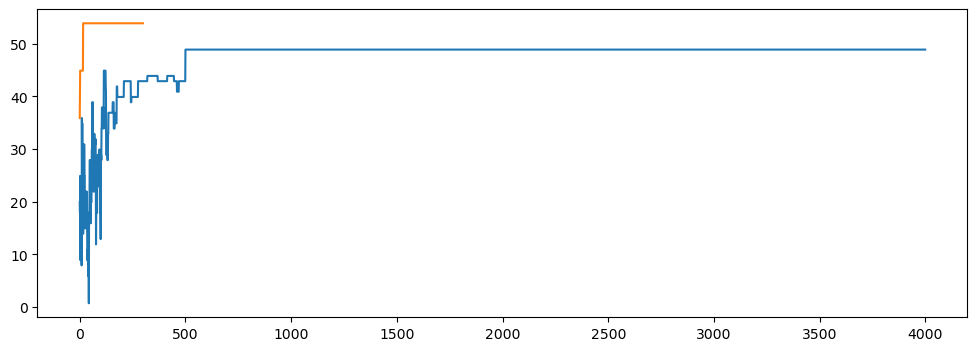

[[1 1 0 1 1 1 1 0 1 1]
 [0 1 1 1 1 0 1 1 0 0]
 [0 0 0 1 1 1 1 0 0 1]
 [0 0 1 0 0 0 1 0 1 0]
 [1 1 1 1 0 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 1 1 0 1 1 0]
 [0 1 0 1 0 1 0 0 1 0]
 [1 0 1 0 0 1 0 1 0 0]
 [1 1 0 1 1 0 0 1 0 1]]
[[0 0 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 1 1 1 0 0]
 [1 0 1 1 1 1 1 0 1 0]
 [1 0 1 0 0 0 0 0 1 1]
 [0 1 1 1 1 0 1 1 1 0]
 [0 0 1 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 1 1 1 1 1 0 1]
 [0 1 1 1 1 0 0 0 1 0]]
20 tur
0
1000
2000
3000


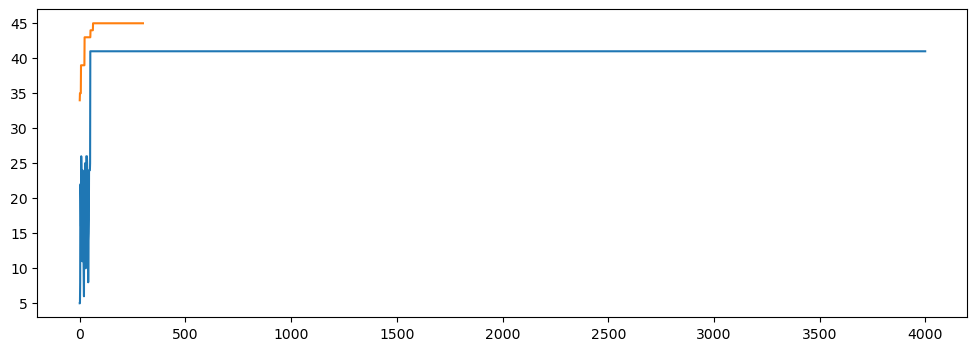

[[0 0 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 0 1]
 [0 0 0 1 1 1 0 0 1 0]
 [0 1 1 1 0 1 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1 0 1]
 [0 1 0 0 1 0 1 1 0 0]
 [1 0 0 0 1 0 1 1 0 0]
 [0 1 1 0 1 1 1 0 0 1]
 [0 0 1 1 1 1 0 0 1 1]]
[[0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 1 0 0]
 [0 1 0 1 1 1 1 0 1 0]
 [1 1 0 1 0 0 1 0 1 1]
 [0 0 0 1 0 1 1 0 1 1]
 [0 0 0 0 0 1 1 0 1 1]
 [0 0 1 0 0 1 1 0 1 1]
 [1 1 0 1 1 0 0 0 0 0]
 [1 1 0 0 1 1 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]]
50 tur
0
1000
2000
3000


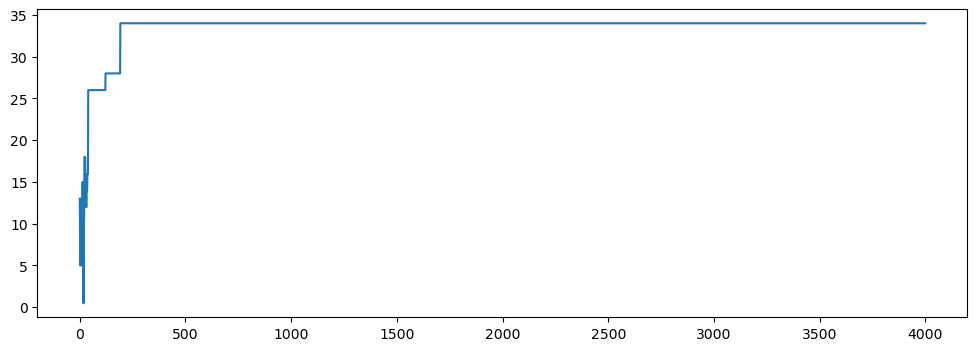

[[1 0 1 1 0 0 0 0 1 0]
 [1 1 1 0 0 0 1 1 0 0]
 [1 1 1 1 0 1 0 1 1 0]
 [1 1 1 0 1 0 1 1 1 1]
 [0 0 0 1 0 0 0 0 1 0]
 [1 0 1 1 1 1 1 0 1 0]
 [0 0 0 1 0 1 0 0 1 1]
 [0 0 0 0 1 0 0 1 1 0]
 [1 0 0 0 1 1 1 0 1 1]
 [0 1 0 1 0 0 0 0 0 0]]
[[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 1 0]
 [1 0 1 1 1 1 0 1 0 1]
 [0 0 1 0 1 1 0 1 0 1]
 [1 0 1 0 0 0 0 1 0 1]
 [1 0 1 1 0 0 0 1 1 0]
 [1 0 0 0 1 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
100 tur
0
1000
2000
3000


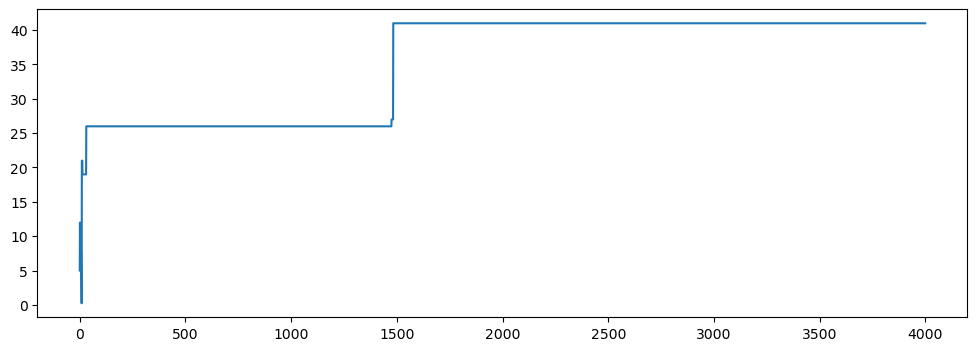

[[0 1 0 0 1 1 1 1 0 1]
 [0 0 1 0 1 1 1 1 0 0]
 [0 0 1 0 1 1 0 1 0 1]
 [0 1 0 0 0 0 1 0 0 1]
 [0 0 0 1 0 1 0 1 1 1]
 [1 0 1 1 1 1 1 0 1 0]
 [0 1 1 0 0 1 0 1 0 0]
 [1 1 0 1 1 0 0 0 0 1]
 [0 1 0 1 0 1 1 1 0 0]
 [0 1 1 0 0 1 1 1 0 0]]
[[0 0 0 0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0 0 0 1]
 [0 0 0 1 0 0 1 1 0 1]
 [0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 1 1 1 0]
 [0 1 1 0 0 0 1 1 1 0]
 [1 0 1 0 0 0 1 1 1 0]
 [1 0 1 0 0 0 0 0 1 1]
 [1 1 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 1 1 0]]


In [36]:
print("simulated annealing 10x10:")
print("10 tur")
annealing_costs, annealing_solution = simulated_annealing( 100, objfuncfor10x10t10, T = 4000 )
printannealingsga(annealing_costs, annealing_solution, 10, 10, 10, data10x10t10[2])

print("20 tur")
annealing_costs, annealing_solution = simulated_annealing( 100, objfuncfor10x10t20, T = 4000 )
printannealingsga(annealing_costs, annealing_solution, 10, 10, 20, data10x10t20[2])

print("50 tur")
annealing_costs, annealing_solution = simulated_annealing( 100, objfuncfor10x10t50, T = 4000 )
printannealing(annealing_costs, annealing_solution, 10, 10, 50)

print("100 tur")
annealing_costs, annealing_solution = simulated_annealing( 100, objfuncfor10x10t100, T = 4000 )
printannealing(annealing_costs, annealing_solution, 10, 10, 100)

simulated annealing 20x20:
10 tur
0
1000
2000
3000


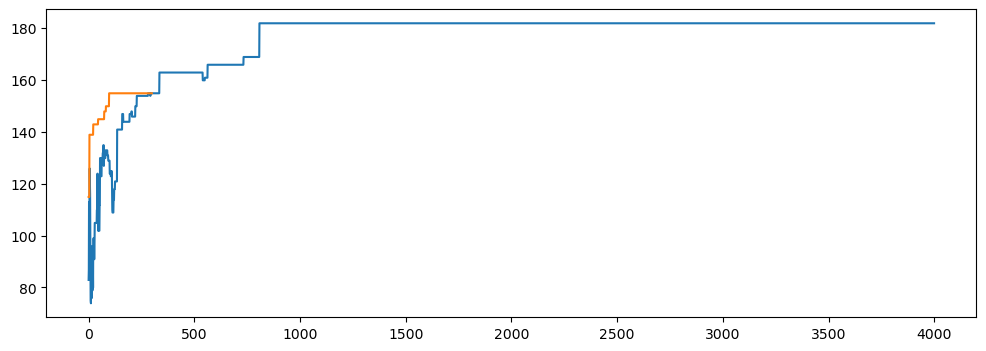

[[1 0 1 1 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1]
 [0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1]
 [1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1]
 [0 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1]
 [0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1]
 [0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0]
 [0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0]
 [1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1]
 [0 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1]
 [1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1]
 [0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 1]
 [1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0]
 [1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0]
 [1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1]
 [1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1]
 [1 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1]
 [1 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1]
 [1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0]
 [0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0]
 [1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 0]]
[[1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0]
 [1 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1]
 [1 1 0 0 

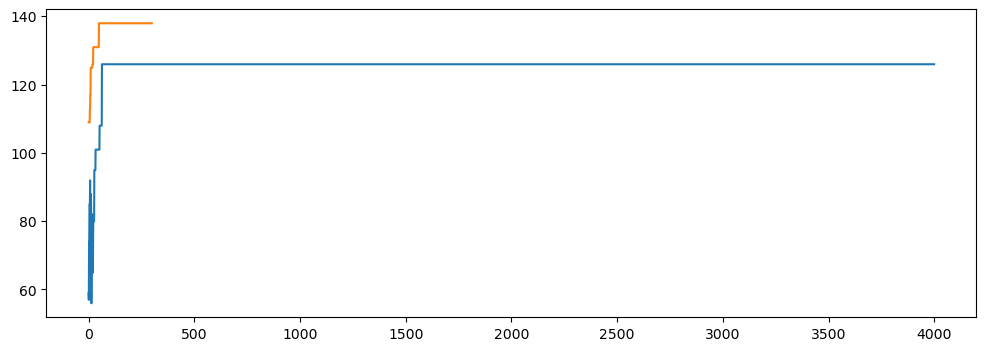

[[1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 1]
 [0 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1]
 [0 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1]
 [1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1]
 [1 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 0]
 [1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0]
 [1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1]
 [0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1]
 [1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0]
 [1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1]
 [1 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 0 1]
 [0 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1]
 [1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0]
 [0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1]
 [1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1]
 [1 1 0 0 0 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1]
 [0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 0]
 [0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 0]
 [0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1]]
[[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
 [1 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0]
 [0 0 0 0 

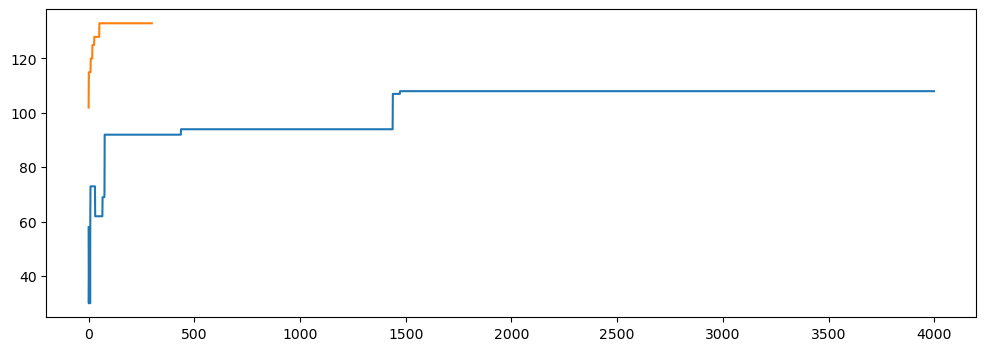

[[0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1]
 [1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1 1 1]
 [1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1]
 [1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1]
 [0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0]
 [1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1]
 [1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1]
 [0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 1]
 [1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1]
 [0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1]
 [0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 1]
 [0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1]
 [0 1 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0]
 [1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1]
 [0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1]
 [0 0 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0]
 [0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1]
 [0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1]
 [0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0]]
[[0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 

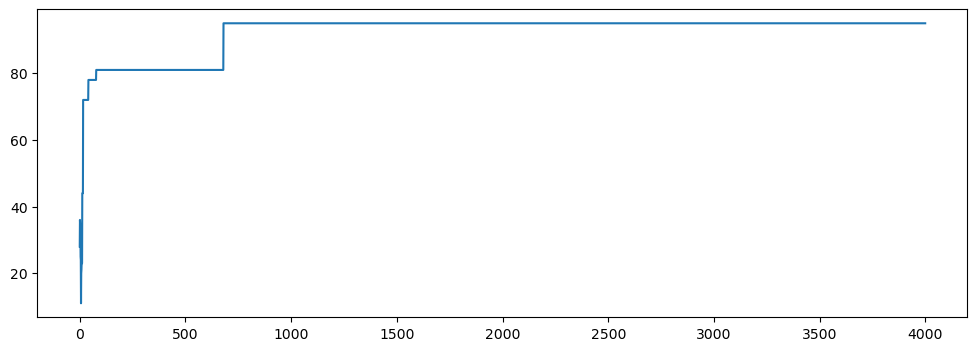

[[0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
 [1 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0]
 [1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0]
 [1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1]
 [1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0]
 [0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1]
 [1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0]
 [1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 1 1]
 [0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1]
 [1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1]
 [1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1]
 [1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 1 0 1]
 [1 1 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 1]
 [1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1]
 [1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 1]
 [0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 1]
 [1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1]
 [1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 

In [37]:
print("simulated annealing 20x20:")
print("10 tur")
annealing_costs, annealing_solution = simulated_annealing( 400, objfuncfor20x20t10, T = 4000 )
printannealingsga(annealing_costs, annealing_solution, 20, 20, 10, data20x20t10[2])

print("20 tur")
annealing_costs, annealing_solution = simulated_annealing( 400, objfuncfor20x20t20, T = 4000 )
printannealingsga(annealing_costs, annealing_solution, 20, 20, 20, data20x20t20[2])

print("50 tur")
annealing_costs, annealing_solution = simulated_annealing( 400, objfuncfor20x20t50, T = 4000 )
printannealingsga(annealing_costs, annealing_solution, 20, 20, 50, datasquare20x20t20[2])

print("100 tur")
annealing_costs, annealing_solution = simulated_annealing( 400, objfuncfor20x20t100, T = 4000 )
printannealing(annealing_costs, annealing_solution, 20, 20, 100)


Algorytm SGA dosyć dobrze sprawdza się dla tego zadania, na poniższym wykresie dla gry 10x10 przy 100 turach widać wynik mocno odbiegający od 1/2 * 100, jednak wynika to głównie z faktu, że dla dłuższych gier ciężej jest znaleźć układ który na długo zachowuje dużo żywych komórek (mają one tendencje do umierania z czasem). Najlepsze rozwiązania dla długiego przebiegu gry to "still life", jednak ciężko oczekiwać, ze SGA uda się wylosować bardzo rzadko występujący układ który się nigdy nie zmienia.

10x10 100 tur:
  0 499.00000000 1047.00000000 2299.00000000 385.87044458
 50 2599.00000000 2650.00000000 3099.00000000  88.87631856
100 3099.00000000 3132.00000000 3499.00000000  93.86692708
150 3399.00000000 3400.00000000 3499.00000000   9.94987437
200 3399.00000000 3401.00000000 3499.00000000  14.00000000
250 3399.00000000 3401.00000000 3499.00000000  14.00000000


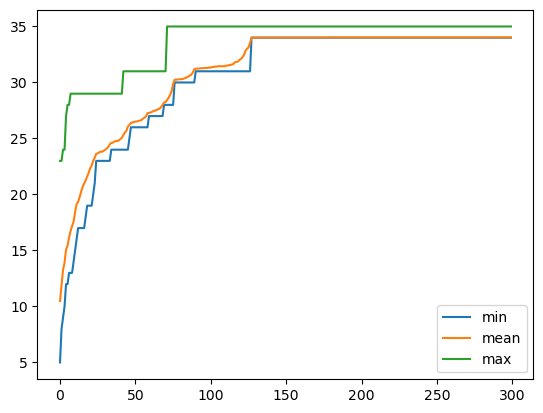

najlepsza plansza na starcie
[[0 1 0 1 0 0 0 0 1 0]
 [1 0 1 1 1 1 0 1 0 1]
 [1 0 0 0 1 1 0 0 0 0]
 [0 1 0 1 0 1 1 0 1 1]
 [0 0 0 1 1 1 1 0 1 0]
 [0 0 1 1 1 1 0 0 1 0]
 [0 0 0 1 1 1 1 1 0 0]
 [0 0 1 0 0 0 0 1 0 1]
 [0 1 1 0 1 1 0 1 1 0]
 [0 0 1 0 0 0 1 1 1 0]]
plansza po  100  turach
[[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 1 1 0 0 0 1]
 [0 0 1 1 0 1 1 0 0 1]
 [0 0 1 1 0 1 0 1 1 1]
 [0 1 1 0 0 1 1 1 0 0]
 [0 0 1 1 0 1 1 1 0 0]
 [0 0 0 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]]


In [26]:

print("10x10 100 tur:")
plotdata, solution = SGA(100, 100, objfuncfor10x10t100, number_of_iterations=300)
plotdata /= 100
makeplots(plotdata, solution, 10, 10, 100)
